# Выбор локации для скважины

Допустим, вы работаете в добывающей компании «ГлавРосГосНефть». Нужно решить, где бурить новую скважину.

Вам предоставлены пробы нефти в трёх регионах: в каждом 10 000 месторождений, где измерили качество нефти и объём её запасов. Постройте модель машинного обучения, которая поможет определить регион, где добыча принесёт наибольшую прибыль. Проанализируйте возможную прибыль и риски техникой *Bootstrap.*

Шаги для выбора локации:

- В избранном регионе ищут месторождения, для каждого определяют значения признаков;
- Строят модель и оценивают объём запасов;
- Выбирают месторождения с самым высокими оценками значений. Количество месторождений зависит от бюджета компании и стоимости разработки одной скважины;
- Прибыль равна суммарной прибыли отобранных месторождений.

## Загрузка и подготовка данных

Используем библиотеки:

In [1]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score
from scipy import stats as st
import numpy as np
from sklearn.metrics import mean_squared_error, r2_score
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.utils import shuffle
from sklearn.preprocessing import OrdinalEncoder 

Данные геологоразведки трёх регионов:

In [2]:
data_0 = pd.read_csv('/datasets/geo_data_0.csv')
data_1 = pd.read_csv('/datasets/geo_data_1.csv')
data_2 = pd.read_csv('/datasets/geo_data_2.csv')

Изучаем данные 1 региона:

In [3]:
data_0.head()

,id,f0,f1,f2,product
0,txEyH,0.705745,-0.497823,1.221170,105.280062
1,2acmU,1.334711,-0.340164,4.365080,73.037750
2,409Wp,1.022732,0.151990,1.419926,85.265647
3,iJLyR,-0.032172,0.139033,2.978566,168.620776
4,Xdl7t,1.988431,0.155413,4.751769,154.036647


In [4]:
data_0.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 5 columns):
 #   Column   Non-Null Count   Dtype  
---  ------   --------------   -----  
 0   id       100000 non-null  object 
 1   f0       100000 non-null  float64
 2   f1       100000 non-null  float64
 3   f2       100000 non-null  float64
 4   product  100000 non-null  float64
dtypes: float64(4), object(1)
memory usage: 3.8+ MB


In [5]:
data_0.corr().style.background_gradient(cmap='coolwarm')

,f0,f1,f2,product
f0,1.000000,-0.440723,-0.003153,0.143536
f1,-0.440723,1.000000,0.001724,-0.192356
f2,-0.003153,0.001724,1.000000,0.483663
product,0.143536,-0.192356,0.483663,1.000000


 <b>Изменения:</b> Колонка id являвется неинформативной, ее нужно удалить

In [6]:
data_0 = data_0.drop(columns='id')
data_1 = data_1.drop(columns='id')
data_2 = data_2.drop(columns='id')

In [7]:
data_0.describe()

,f0,f1,f2,product
count,100000.000000,100000.000000,100000.000000,100000.000000
mean,0.500419,0.250143,2.502647,92.500000
std,0.871832,0.504433,3.248248,44.288691
min,-1.408605,-0.848218,-12.088328,0.000000
25%,-0.072580,-0.200881,0.287748,56.497507
50%,0.502360,0.250252,2.515969,91.849972
75%,1.073581,0.700646,4.715088,128.564089
max,2.362331,1.343769,16.003790,185.364347


Изучаем данные 2 региона:

In [8]:
data_1.head()

,f0,f1,f2,product
0,-15.001348,-8.276000,-0.005876,3.179103
1,14.272088,-3.475083,0.999183,26.953261
2,6.263187,-5.948386,5.001160,134.766305
3,-13.081196,-11.506057,4.999415,137.945408
4,12.702195,-8.147433,5.004363,134.766305


In [9]:
data_1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 4 columns):
 #   Column   Non-Null Count   Dtype  
---  ------   --------------   -----  
 0   f0       100000 non-null  float64
 1   f1       100000 non-null  float64
 2   f2       100000 non-null  float64
 3   product  100000 non-null  float64
dtypes: float64(4)
memory usage: 3.1 MB


In [10]:
data_1.describe()

,f0,f1,f2,product
count,100000.000000,100000.000000,100000.000000,100000.000000
mean,1.141296,-4.796579,2.494541,68.825000
std,8.965932,5.119872,1.703572,45.944423
min,-31.609576,-26.358598,-0.018144,0.000000
25%,-6.298551,-8.267985,1.000021,26.953261
50%,1.153055,-4.813172,2.011479,57.085625
75%,8.621015,-1.332816,3.999904,107.813044
max,29.421755,18.734063,5.019721,137.945408


In [11]:
data_1.corr().style.background_gradient(cmap='coolwarm')

,f0,f1,f2,product
f0,1.000000,0.182287,-0.001777,-0.030491
f1,0.182287,1.000000,-0.002595,-0.010155
f2,-0.001777,-0.002595,1.000000,0.999397
product,-0.030491,-0.010155,0.999397,1.000000


Изучаем данные 3 региона:

In [12]:
data_2.head()

,f0,f1,f2,product
0,-1.146987,0.963328,-0.828965,27.758673
1,0.262778,0.269839,-2.530187,56.069697
2,0.194587,0.289035,-5.586433,62.871910
3,2.236060,-0.553760,0.930038,114.572842
4,-0.515993,1.716266,5.899011,149.600746


In [13]:
data_2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 4 columns):
 #   Column   Non-Null Count   Dtype  
---  ------   --------------   -----  
 0   f0       100000 non-null  float64
 1   f1       100000 non-null  float64
 2   f2       100000 non-null  float64
 3   product  100000 non-null  float64
dtypes: float64(4)
memory usage: 3.1 MB


In [14]:
data_2.describe()

,f0,f1,f2,product
count,100000.000000,100000.000000,100000.000000,100000.000000
mean,0.002023,-0.002081,2.495128,95.000000
std,1.732045,1.730417,3.473445,44.749921
min,-8.760004,-7.084020,-11.970335,0.000000
25%,-1.162288,-1.174820,0.130359,59.450441
50%,0.009424,-0.009482,2.484236,94.925613
75%,1.158535,1.163678,4.858794,130.595027
max,7.238262,7.844801,16.739402,190.029838


In [15]:
data_2.corr().style.background_gradient(cmap='coolwarm')

,f0,f1,f2,product
f0,1.000000,0.000528,-0.000448,-0.001987
f1,0.000528,1.000000,0.000779,-0.001012
f2,-0.000448,0.000779,1.000000,0.445871
product,-0.001987,-0.001012,0.445871,1.000000


Построим график:

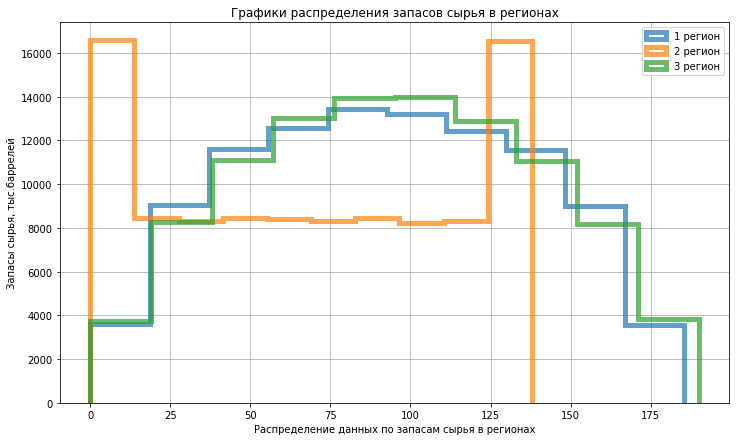

In [16]:
plt.title('Графики распределения запасов сырья в регионах')
ax=data_0['product'].plot(kind='hist',figsize=(12,7),grid=True, legend=True, alpha=0.7, histtype='step', linewidth=5, label='1 регион')
ax1=data_1['product'].plot(kind='hist',figsize=(12,7),grid=True, legend=True, alpha=0.7,histtype='step', linewidth=5, label='2 регион', ax=ax)
data_2['product'].plot(kind='hist',figsize=(12,7),grid=True, legend=True, alpha=0.7,histtype='step', linewidth=5, label='3 регион', ax=ax1)
plt.xlabel('Распределение данных по запасам сырья в регионах')
plt.ylabel('Запасы сырья, тыс.баррелей')
plt.show()

Вывод:

Данные загружены и не требуют дополнительной предобработки.

Имеем визуальное представление о распределении данных по запасам сырья в регионах.

На графике показана разительно отличающаяся кривая распределения запасов сырья по скважинам 2 региона.

Отметим так же, что на данных по корреляции значений 2 регоина, мы видим сильную зависимость целевого показателя product от f0, такая зависмость можеть дать нам высокие баллы предсказаний для нашей модели.

## Обучение и проверка модели

Разбиваем данные на обучающую и валидационную выборки в соотношении 75:25.

In [17]:
target_0=data_0['product']
features_0=data_0.drop(['product'], axis=1)

target_1=data_1['product']
features_1=data_1.drop(['product'], axis=1)

target_2=data_2['product']
features_2=data_2.drop(['product'], axis=1)

1 регион

In [18]:
features_train_0, features_valid_0, target_train_0, target_valid_0 = train_test_split(features_0, target_0, test_size=0.25, random_state=42)
tv=target_valid_0.shape[0]/target_0.shape[0]
tt=target_train_0.shape[0]/target_0.shape[0]

print('Размер тренировочной выборки- {:.0%}'.format(tt))
print('Размер валидационной выборки - {:.0%}'.format(tv))

Размер тренировочной выборки- 75%
Размер валидационной выборки - 25%


2 регион

In [19]:
features_train_1, features_valid_1, target_train_1, target_valid_1 = train_test_split(features_1, target_1, test_size=0.25, random_state=42)
tv=target_valid_1.shape[0]/target_1.shape[0]
tt=target_train_1.shape[0]/target_1.shape[0]

print('Размер тренировочной выборки- {:.0%}'.format(tt))
print('Размер валидационной выборки - {:.0%}'.format(tv))

Размер тренировочной выборки- 75%
Размер валидационной выборки - 25%


3 регион

In [20]:
features_train_2, features_valid_2, target_train_2, target_valid_2 = train_test_split(features_2, target_2, test_size=0.25, random_state=42)
tv=target_valid_2.shape[0]/target_2.shape[0]
tt=target_train_2.shape[0]/target_2.shape[0]

print('Размер тренировочной выборки- {:.0%}'.format(tt))
print('Размер валидационной выборки - {:.0%}'.format(tv))

Размер тренировочной выборки- 75%
Размер валидационной выборки - 25%


Обучаем модель и делаем предсказания на валидационной выборке.

1 регион

In [21]:
model_0=LinearRegression()
model_0.fit(features_train_0,target_train_0)
predict_0=model_0.predict(features_valid_0)
rmse_0 = mean_squared_error(target_valid_0, predict_0)**0.5
print('Среднеквадратичная ошибка RMSE: %.2f'% rmse_0)
print('Коэффициент детерминации: %.2f' % r2_score(target_valid_0, predict_0))

Среднеквадратичная ошибка RMSE: 37.76
Коэффициент детерминации: 0.27


2 регион

In [22]:
model_1=LinearRegression()
model_1.fit(features_train_1,target_train_1)
predict_1=model_1.predict(features_valid_1)
rmse_1=mean_squared_error(target_valid_1, predict_1)**0.5
print('Среднеквадратичная ошибка RMSE: %.2f' % rmse_1)
print('Коэффициент детерминации: %.2f' % r2_score(target_valid_1, predict_1))

Среднеквадратичная ошибка RMSE: 0.89
Коэффициент детерминации: 1.00


3 регион

In [23]:
model_2=LinearRegression()
model_2.fit(features_train_2,target_train_2)
predict_2=model_2.predict(features_valid_2)
rmse_2 = mean_squared_error(target_valid_2, predict_2)**0.5
print('Среднеквадратичная ошибка RMSE: %.2f'% rmse_2)
print('Коэффициент детерминации: %.2f' % r2_score(target_valid_2, predict_2))

Среднеквадратичная ошибка RMSE: 40.15
Коэффициент детерминации: 0.20


Сохраним предсказания и правильные ответы на валидационной выборке.

In [24]:
print('1 регион:\n- предсказания модели: "predict_0"\n- правильные ответы: "target_valid_0"')
print()
print('2 регион:\n- предсказания модели: "predict_1"\n- правильные ответы: "target_valid_1"')
print()
print('3 регион:\n- предсказания модели: "predict_2"\n- правильные ответы: "target_valid_2"')

1 регион:
- предсказания модели: "predict_0"
- правильные ответы: "target_valid_0"

2 регион:
- предсказания модели: "predict_1"
- правильные ответы: "target_valid_1"

3 регион:
- предсказания модели: "predict_2"
- правильные ответы: "target_valid_2"


Напечатаем на экране средний запас предсказанного сырья и RMSE модели

In [25]:
comparison_tabl = pd.DataFrame(index=['средний запас предсказанного сырья','RMSE модели'], columns=['1 регион','2 регион','3 регион'])
comparison_tabl['1 регион'] = predict_0.mean(), rmse_0
comparison_tabl['2 регион'] = predict_1.mean(), rmse_1
comparison_tabl['3 регион'] = predict_2.mean(), rmse_2
comparison_tabl

,1 регион,2 регион,3 регион
средний запас предсказанного сырья,92.3988,68.712878,94.771024
RMSE модели,37.7566,0.890280,40.145872


Вывод:

Модели обучены и проверены на качество предсказания метрикой RMSE, которая определяет величину среднеквадратичной ошибки в предсказании модели. 

Исходя из полученных данный в нашей сводной таблицы, можно заметить, что величина RMSE во втором регионе сильно отличается от двух других, это связано с тем, что модель обучилась на практически равных по величине данных, и величина ошибки этой модели не может сильно варьирываться.

## Подготовка к расчёту прибыли

Условия задачи:

Для обучения модели подходит только линейная регрессия (остальные — недостаточно предсказуемые).
При разведке региона исследуют 500 точек, из которых с помощью машинного обучения выбирают 200 лучших для разработки.
Бюджет на разработку скважин в регионе — 10 млрд рублей.

При нынешних ценах один баррель сырья приносит 450 рублей дохода. Доход с каждой единицы продукта составляет 450 тыс. рублей, поскольку объём указан в тысячах баррелей.

После оценки рисков нужно оставить лишь те регионы, в которых вероятность убытков меньше 2.5%. Среди них выбирают регион с наибольшей средней прибылью.

Все ключевые значения для расчётов сохраним в отдельных переменных.

In [26]:
BUDGET = 10000000 
INCOME_ONE_PROD = 450 
target_probability_losses = 2.5/100 
product_mean_0 = data_0['product'].mean()
product_mean_1 = data_1['product'].mean()
product_mean_2 = data_2['product'].mean()

In [27]:
print('Cредний запас сырья в 1 регионе: %.2f млн.баррелей'%product_mean_0)
print('Cредний запас сырья в 2 регионе: %.2f млн.баррелей'%product_mean_1)
print('Cредний запас сырья в 3 регионе: %.2f млн.баррелей'%product_mean_2)

Cредний запас сырья в 1 регионе: 92.50 млн.баррелей
Cредний запас сырья в 2 регионе: 68.83 млн.баррелей
Cредний запас сырья в 3 регионе: 95.00 млн.баррелей


In [28]:
budg_per_1_point=(BUDGET/200)# тыс.руб
print('Бюджет на разработку одной скважины:', budg_per_1_point/1000,'млн.руб')

Бюджет на разработку одной скважины: 50.0 млн.руб


Рассчитаем достаточный объём сырья для безубыточной разработки новой скважины

In [29]:
v_prod=budg_per_1_point/INCOME_ONE_PROD
print('Объём каждой скважины для безубыточной разработки должен составлять не менее: %.2f'%v_prod,'тыс.баррелей')

Объём каждой скважины для безубыточной разработки должен составлять не менее: 111.11 тыс.баррелей


Сравним полученный объём сырья со средним запасом в каждом регионе

1 регион

In [30]:
data_0['profit']=(data_0['product']*(INCOME_ONE_PROD)).round(2) 
data_0.head()

,f0,f1,f2,product,profit
0,0.705745,-0.497823,1.221170,105.280062,47376.03
1,1.334711,-0.340164,4.365080,73.037750,32866.99
2,1.022732,0.151990,1.419926,85.265647,38369.54
3,-0.032172,0.139033,2.978566,168.620776,75879.35
4,1.988431,0.155413,4.751769,154.036647,69316.49


In [31]:
data_0['roi_%']=((data_0['profit']-budg_per_1_point)/budg_per_1_point*100).round(2)
data_0.head()

,f0,f1,f2,product,profit,roi_%
0,0.705745,-0.497823,1.221170,105.280062,47376.03,-5.25
1,1.334711,-0.340164,4.365080,73.037750,32866.99,-34.27
2,1.022732,0.151990,1.419926,85.265647,38369.54,-23.26
3,-0.032172,0.139033,2.978566,168.620776,75879.35,51.76
4,1.988431,0.155413,4.751769,154.036647,69316.49,38.63


In [32]:
print('Разница объёма сырья для безубыточной разработки скважины относительно среднего значения по 1 региону составляет: {:.2%}'.format(product_mean_0/v_prod-1))
print('Или {:.2f} тыс.баррелей'.format(v_prod-product_mean_0))

Разница объёма сырья для безубыточной разработки скважины относительно среднего значения по 1 региону составляет: -16.75%
Или 18.61 тыс.баррелей


2 регион

In [33]:
data_1['profit']=(data_1['product']*INCOME_ONE_PROD).round(2)
data_1.head()

,f0,f1,f2,product,profit
0,-15.001348,-8.276000,-0.005876,3.179103,1430.60
1,14.272088,-3.475083,0.999183,26.953261,12128.97
2,6.263187,-5.948386,5.001160,134.766305,60644.84
3,-13.081196,-11.506057,4.999415,137.945408,62075.43
4,12.702195,-8.147433,5.004363,134.766305,60644.84


In [34]:
data_1['roi_%']=((data_1['profit']-budg_per_1_point)/budg_per_1_point*100).round(2)
data_1.head()

,f0,f1,f2,product,profit,roi_%
0,-15.001348,-8.276000,-0.005876,3.179103,1430.60,-97.14
1,14.272088,-3.475083,0.999183,26.953261,12128.97,-75.74
2,6.263187,-5.948386,5.001160,134.766305,60644.84,21.29
3,-13.081196,-11.506057,4.999415,137.945408,62075.43,24.15
4,12.702195,-8.147433,5.004363,134.766305,60644.84,21.29


In [35]:
print('Разница объёма сырья для безубыточной разработки скважины относительно среднего значения по 2 региону составляет: {:.2%}'.format(product_mean_1/v_prod-1))
print('Или {:.2f} тыс.баррелей'.format(v_prod-product_mean_1))

Разница объёма сырья для безубыточной разработки скважины относительно среднего значения по 2 региону составляет: -38.06%
Или 42.29 тыс.баррелей


3 регион

In [36]:
data_2['profit']=(data_2['product']*INCOME_ONE_PROD).round(2) 
data_2.head()

,f0,f1,f2,product,profit
0,-1.146987,0.963328,-0.828965,27.758673,12491.40
1,0.262778,0.269839,-2.530187,56.069697,25231.36
2,0.194587,0.289035,-5.586433,62.871910,28292.36
3,2.236060,-0.553760,0.930038,114.572842,51557.78
4,-0.515993,1.716266,5.899011,149.600746,67320.34


In [37]:
data_2['roi_%']=((data_2['profit']-budg_per_1_point)/budg_per_1_point*100).round(2)
data_2.head()

,f0,f1,f2,product,profit,roi_%
0,-1.146987,0.963328,-0.828965,27.758673,12491.40,-75.02
1,0.262778,0.269839,-2.530187,56.069697,25231.36,-49.54
2,0.194587,0.289035,-5.586433,62.871910,28292.36,-43.42
3,2.236060,-0.553760,0.930038,114.572842,51557.78,3.12
4,-0.515993,1.716266,5.899011,149.600746,67320.34,34.64


In [38]:
print('Разница объёма сырья для безубыточной разработки скважины относительно среднего значения по 3 региону составляет: {:.2%}'.format(product_mean_2/v_prod-1))
print('Или {:.2f} тыс.баррелей'.format(v_prod-product_mean_2))

Разница объёма сырья для безубыточной разработки скважины относительно среднего значения по 3 региону составляет: -14.50%
Или 16.11 тыс.баррелей


Вывод:

Среднее количество запасов сырья по регионам недостаточное даже для окупаемости разработки, требуется выбрать скважины с максимальными запасами

## Функция для расчёта прибыли по выбранным скважинам и предсказаниям модели:

Выберем скважины с максимальными значениями предсказаний

In [39]:
predict_0

array([101.90101715,  78.21777385, 115.26690103, ...,  82.54439653,
        81.82668931,  93.12106221])

In [40]:
probs_sorted_0 = pd.Series(predict_0, index=target_valid_0.index).sort_values(ascending=False)
selected_max_0 = probs_sorted_0[:200]
selected_max_0

46784    176.536104
27658    176.274510
6496     173.249504
65743    172.802708
93716    172.744977
            ...    
14042    146.952653
65925    146.948764
65549    146.947483
9462     146.946515
39838    146.874947
Length: 200, dtype: float64

Просуммируем целевое значение объёма сырья, соответствующее этим предсказаниям

In [41]:
selected_max_0_sum = selected_max_0.sum()
print('Суммарный запас сырья в 200 лучших скважинах составит: %.2f тыс.баррелей'%selected_max_0_sum)

Суммарный запас сырья в 200 лучших скважинах составит: 30881.46 тыс.баррелей


Рассчитаем прибыль для полученного объёма сырья

In [42]:
profit_pred_0=(selected_max_0_sum*INCOME_ONE_PROD)-BUDGET
print('Прибыль для полученного объёма сырья составит %.2f тыс.рублей'%profit_pred_0)

Прибыль для полученного объёма сырья составит 3896658.48 тыс.рублей


Напишем функцию:

In [43]:
def profit_for_vp(predict,target,count):
    probs_sorted = pd.Series(predict, index=target.index).sort_values(ascending=False)
    selected_max = probs_sorted[:count].sum()
    profit_pred=(selected_max*INCOME_ONE_PROD)-BUDGET
    print('Суммарный запас сырья в 200 лучших скважинах составит: %.2f тыс.баррелей'%selected_max)
    print('Прибыль для полученного объёма сырья составит %.2f млн.рублей'%(profit_pred/1000))

1 регион

In [44]:
profit_for_vp(predict_0,target_valid_0,200)

Суммарный запас сырья в 200 лучших скважинах составит: 30881.46 тыс.баррелей
Прибыль для полученного объёма сырья составит 3896.66 млн.рублей


2 регион

In [45]:
profit_for_vp(predict_1,target_valid_1,200)

Суммарный запас сырья в 200 лучших скважинах составит: 27748.75 тыс.баррелей
Прибыль для полученного объёма сырья составит 2486.94 млн.рублей


3 регион

In [46]:
profit_for_vp(predict_2,target_valid_2,200)

Суммарный запас сырья в 200 лучших скважинах составит: 29728.85 тыс.баррелей
Прибыль для полученного объёма сырья составит 3377.98 млн.рублей


Вывод:

Все три региона потенциально прибыльные.

## Расчёт прибыли и рисков 

Применим технику Bootstrap с 1000 выборок, чтобы найти распределение прибыли

In [47]:
def profit_for_vp2(predict,target,count):
    probs_sorted = pd.Series(predict).sort_values(ascending=False)
    selected_points = target[probs_sorted.index][:count]
    product = selected_points.sum()
    revenue = product * INCOME_ONE_PROD
    return revenue - BUDGET

In [48]:
def bootstap_1000(target,predict):
    values = []
    count=0
    state = np.random.RandomState(12345)
    predict_e = pd.Series(predict, index=target.index)
    
    for i in tqdm(range(1000)):
        target_subsample = target.sample(n=500,replace=True, random_state=state)
  
        probs_subsample = predict_e[target_subsample.index]
        values.append(profit_for_vp2(probs_subsample,target_subsample, 200))  
    for i in values:
        if i < 0:
            count +=1
            
    values = pd.Series(values)
    mean = values.mean()
    confidence_interval = st.t.interval(0.95, len(values)-1, values.mean(), values.sem())
    
    plt.title('Распределение прибыли')
    values.plot(kind="hist", grid=True, figsize=(8,5))
    plt.xlabel('Прибыль, тыс.руб')
    plt.ylabel('Количество')
    plt.show()
    
    low_95 = values.quantile(0.025)
    high_95 = values.quantile(0.975)
    
    print("Средняя прибыль: {:.2f} млн.руб".format(mean/1000))
    print('С вероятностью 95% прибыль в данном регионе будет составлять от: {:.2f} млн.руб до: {:.2f} млн.руб'.format((low_95/1000),(high_95/1000)))
    print("95%-ый доверительный интервал: от {:.2f} млн.руб до {:.2f} млн.руб". format((confidence_interval[0]/1000),(confidence_interval[1]/1000)))
    print ('Процент вероятности убытка в данном регионе составит {:.1%}'.format(count/1000))

Распределение прибыли 1 регион

  0%|          | 0/1000 [00:00<?, ?it/s]

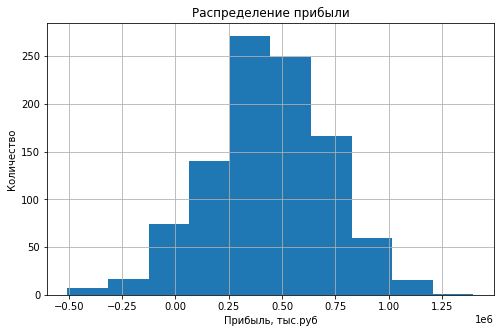

Средняя прибыль: 435.93 млн.руб
С вероятностью 95% прибыль в данном регионе будет составлять от: -116.23 млн.руб до: 966.50 млн.руб
95%-ый доверительный интервал: от 418.76 млн.руб до 453.11 млн.руб
Процент вероятности убытка в данном регионе составит 6.1%


In [49]:
bootstap_1000(target_valid_0,predict_0)

Распределение прибыли 2 регион

  0%|          | 0/1000 [00:00<?, ?it/s]

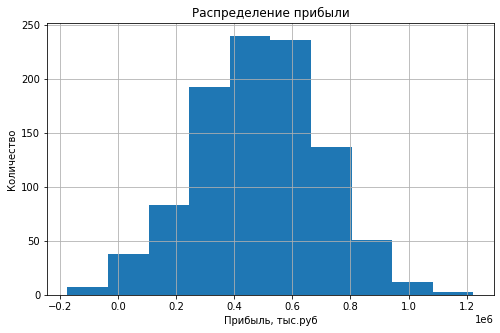

Средняя прибыль: 489.66 млн.руб
С вероятностью 95% прибыль в данном регионе будет составлять от: 55.12 млн.руб до: 905.76 млн.руб
95%-ый доверительный интервал: от 476.23 млн.руб до 503.09 млн.руб
Процент вероятности убытка в данном регионе составит 1.1%


In [50]:
bootstap_1000(target_valid_1,predict_1)

Распределение прибыли 3 регион

  0%|          | 0/1000 [00:00<?, ?it/s]

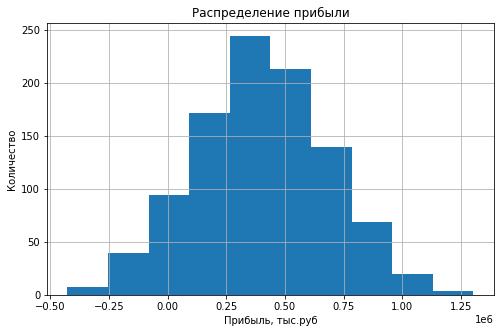

Средняя прибыль: 403.69 млн.руб
С вероятностью 95% прибыль в данном регионе будет составлять от: -153.12 млн.руб до: 952.89 млн.руб
95%-ый доверительный интервал: от 386.21 млн.руб до 421.17 млн.руб
Процент вероятности убытка в данном регионе составит 7.1%


In [51]:
bootstap_1000(target_valid_2,predict_2)


Выбор региона.

In [52]:
comparison_tabl = pd.DataFrame(index=['Средняя прибыль в регионе, млн.руб','Суммарный запас сырья, тыс.баррелей','Вероятность убытка, %'], columns=['1 регион','2 регион','3 регион'])
comparison_tabl['1 регион'] = '435.84', '30881.96','6.2'
comparison_tabl['2 регион'] = '489.66', '27748.75','1.1'
comparison_tabl['3 регион'] = '403.95', '29730.68','7.0'
comparison_tabl

,1 регион,2 регион,3 регион
"Средняя прибыль в регионе, млн.руб",435.84,489.66,403.95
"Суммарный запас сырья, тыс.баррелей",30881.96,27748.75,29730.68
"Вероятность убытка, %",6.2,1.1,7.0


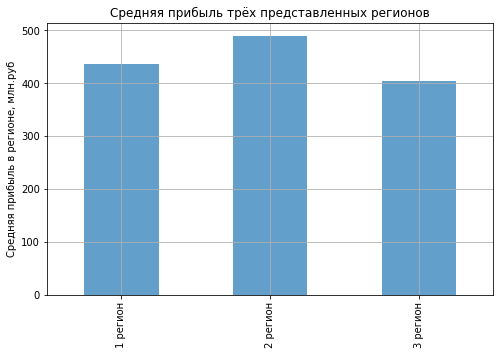

In [53]:
comparison_tabl.astype('float').iloc[0,:].plot(kind="bar", figsize=(8,5), grid=True, alpha=0.7, subplots=True)
plt.title('Средняя прибыль трёх представленных регионов')
plt.ylabel('Средняя прибыль в регионе, млн.руб')
plt.show()

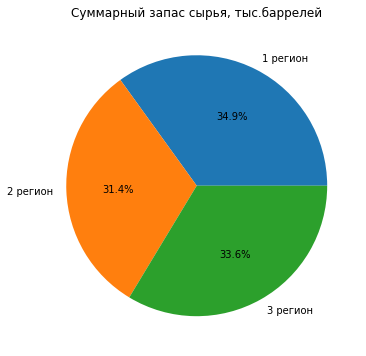

In [54]:
comparison_tabl.astype('float').iloc[1,:].plot(kind='pie', figsize=(6,6),autopct='%1.1f%%', subplots=True)
plt.title('Суммарный запас сырья, тыс.баррелей')
plt.ylabel('')
plt.show()

Вывод:

Согласно распределению среднего значения прибыли с региона, самым прибыльным оказался 2 регион, средняя прибыль в этом регионе составит 489.66 млн.рублей. Два других региона не прошли отбор по минимально допустимому порогу убытка в 2,5%.

Таким образом не смотря на сравнительно меньшие запасы сырья, по сравнению с другими регионами, средняя доходность со скважин во втором регионе прогнозируется выше других.

Общий вывод:

Мы исследовали данные по запасам в скважинах трёх регионов, в каждом из которых были данные о запасах сырья по 10 тыс.скважинам. При первом знакомстве с данными мы обнаружили, что средний запас ресурсов по регионам недостаточен даже для окупаемости вложений на разработку и для того, чтобы иметь уверенность в перспективе разработки по регионам, мы обучили модель и выполнили предсказания при помощи линейной регрессии, а так же применили технологию bootstrap с разделением каждого предсказанного значения прибыли по регионам на 1000 выборок.

По результату полученных данных мы определили доверительный интревал получения прибыли в 95%, ограничив вероятность убытка величиной менее 2,5%. И на основе этих данных смогли выбрать более перспективный регион для разработки 200 скважин.

Таким образом не смотря на сравнительно меньшие предсказания запасов сырья в 27.75 млн.баррелей (по сравнению с другими регионами), с величиной вероятного возникновения убытка в 1,1%, но с превышающей средней прибылью в 489.66 млн.рублей мы сдели выбор в сторону разработки 200 скважин во 2 регионе.